# **Import modules to handle dataframes, plotting, graphing centrality, and shortest path**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors

# **Load movie data into dataframes, and drop unwanted rows**

In [2]:
local_file = 'watchlist.txt'
header_field = ['tconst']
watchlist_info = pd.read_csv(local_file, names=header_field)
watchlist = []
watchlist = watchlist_info['tconst'].tolist() # refactor this to load direct to list, don't need a df

In [3]:
local_file = 'movie_info.csv'
movie_info = pd.read_csv(local_file, sep='\t')

In [4]:
movie_info = movie_info[movie_info['tconst'].isin(watchlist) == True]  # drop movies not on/by Hallmark

In [5]:
local_file = 'cast_crew_info.csv'
cast_crew_info = pd.read_csv(local_file, sep='\t')

In [6]:
actorlist = cast_crew_info['nconst'].tolist()  # all the Hallmark actors
actorlist = list(set(actorlist))

In [7]:
cast_crew_info = cast_crew_info[cast_crew_info['nconst'].isin(actorlist) == True]  # drop people not in Hallmark

In [8]:
#local_file = 'movie_crew.csv'  # may be able to use for ML, but not yet
#movie_crew = pd.read_csv(local_file, sep='\t')

In [9]:
#movie_crew = movie_crew[movie_crew['tconst'].isin(watchlist) == True]  # drop people not associated w/Hallmark

In [10]:
local_file = 'movie_cast_crew.csv'
movie_cast_crew = pd.read_csv(local_file, sep='\t')

In [11]:
movie_cast_crew = movie_cast_crew[movie_cast_crew['tconst'].isin(watchlist) == True]  # drop non-Hallmark related

In [12]:
unwantedValues = ['composer', 'cinematographer', 'editor', 'production_designer', 
                  'self']  # leave sactor, actress, writer, producer, director categories

In [13]:
movie_cast_crew = movie_cast_crew[movie_cast_crew['category'].isin(unwantedValues) == False] 
# keep actor, actress rows

In [14]:
movielist = movie_cast_crew['tconst'].tolist()  # all the Hallmark movies
movielist = list(set(movielist))

# **Create lookup dictionaries for all four tables**

In [15]:
df = movie_cast_crew.groupby('nconst')['tconst'].apply(list).reset_index(name="movieList")

In [16]:
nm_tt = dict(zip(df.nconst, df.movieList))  # list of movies each actor starred in

In [17]:
df = movie_cast_crew.groupby('tconst')['nconst'].apply(list).reset_index(name="actorList")

In [18]:
tt_nm = dict(zip(df.tconst, df.actorList))  # list for dictionary lookup of actors in a movie

In [19]:
df = cast_crew_info  # source of ID no, full name, birth year, death year, etc.

In [20]:
nm_name = dict(zip(df.nconst, df.primaryName))  # create a lookup dictionary

In [21]:
df = movie_info  # includes title, release year, runtime, ratings, num votes

In [22]:
tt_title = dict(zip(df.tconst, df.primaryTitle)) # create lookup table

In [23]:
title_tt = dict(zip(df.primaryTitle, df.tconst))  # create a dictionary mapping movie titles to codes

In [24]:
tt_rating = dict(zip(df.tconst, df.averageRating)) # create lookup table

In [25]:
title_rating = dict(zip(df.primaryTitle, df.averageRating)) # create lookup table

# **Analyze movie data using basic visualizations**

In [26]:
%matplotlib inline

In [27]:
df = movie_info  #let's start with the movie database

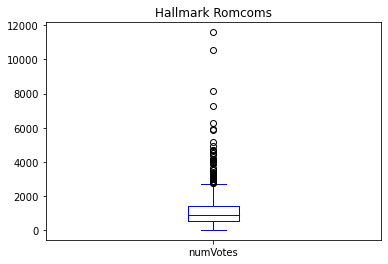

In [28]:
df.numVotes.plot(kind='box', title='Hallmark Romcoms', color='b');  #older, more popular probably get more votes

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 0 to 1140
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          1141 non-null   object 
 1   titleType       1141 non-null   object 
 2   primaryTitle    1141 non-null   object 
 3   startYear       1141 non-null   object 
 4   runtimeMinutes  1141 non-null   int64  
 5   genres          1141 non-null   object 
 6   averageRating   1141 non-null   float64
 7   numVotes        1141 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 80.2+ KB


In [30]:
df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce') #convert to float
df['startYear'] = df['startYear'].astype("Int64") #then back to integer (refactor later)

In [31]:
df.info()  #that's better!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 0 to 1140
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          1141 non-null   object 
 1   titleType       1141 non-null   object 
 2   primaryTitle    1141 non-null   object 
 3   startYear       1136 non-null   Int64  
 4   runtimeMinutes  1141 non-null   int64  
 5   genres          1141 non-null   object 
 6   averageRating   1141 non-null   float64
 7   numVotes        1141 non-null   int64  
dtypes: Int64(1), float64(1), int64(2), object(4)
memory usage: 81.3+ KB


In [32]:
plt.rcParams["figure.figsize"] = (8,4)

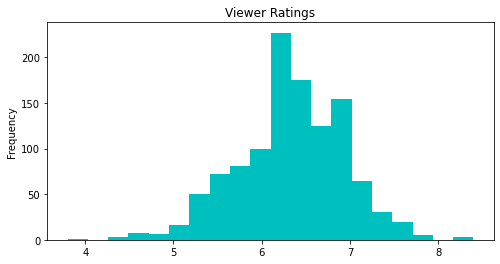

In [33]:
df.averageRating.plot(kind='hist',
                      title='Viewer Ratings',
                      color='c',
                      bins=20);  # most people rate movies between 5 and 7, mostly in 6 range

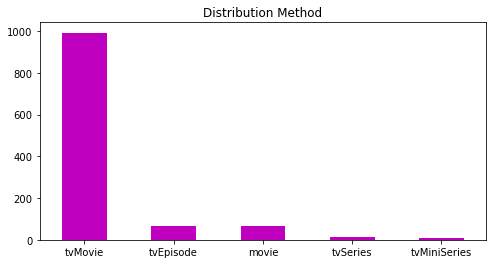

In [34]:
df.titleType.value_counts().plot(kind='bar',
                                 rot=0,
                                 title='Distribution Method',
                                 color='m');  # could probably drop lowest categories - should be more tvSeries?

In [35]:
df.groupby(['titleType']).agg({ 'numVotes': 'mean', 'averageRating': 'mean', 'runtimeMinutes': 'median' }) 

,numVotes,averageRating,runtimeMinutes
titleType,,,
movie,770.234375,5.795312,88.0
tvEpisode,753.545455,6.862121,84.0
tvMiniSeries,281.428571,7.285714,80.0
tvMovie,1150.806452,6.304335,85.0
tvSeries,833.750000,7.450000,80.0


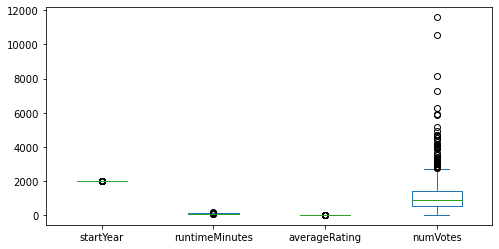

In [36]:
df.plot(kind='box');

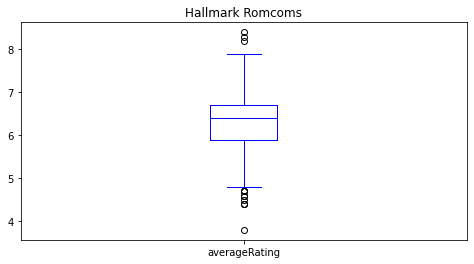

In [37]:
df.averageRating.plot(kind='box', title='Hallmark Romcoms', color='b');  # mirrors what we saw in bar graph

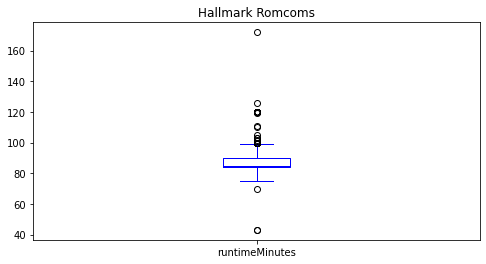

In [38]:
df.runtimeMinutes.plot(kind='box', title='Hallmark Romcoms', color='b');

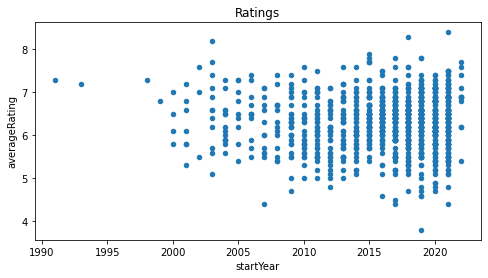

In [39]:
df.plot.scatter(x='startYear', y='averageRating', title="Ratings");  # social media influence? COVID?

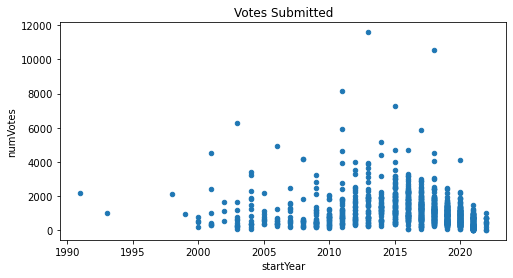

In [40]:
df.plot.scatter(x='startYear', y='numVotes', title="Votes Submitted"); # less votes, more movies?

In [41]:
annual_volume = pd.crosstab(df.startYear, df.titleType)[-14:-1]  # number of movies produced annually in recent years

Text(0.5, 1.0, 'Production Increase\n')

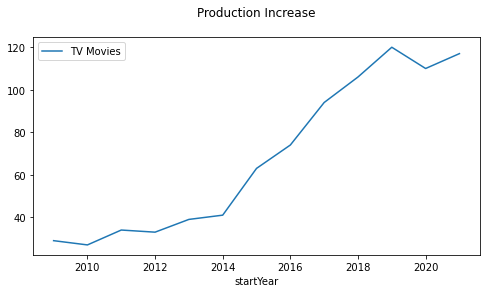

In [42]:
annual_volume.tvMovie.plot(kind='line')
annual_volume.index.names = ['Year']  # change the index for graph
plt.legend(['TV Movies'])
plt.title('Production Increase\n')

In [43]:
pd.crosstab(df.startYear, df.titleType)[-14:-1]

titleType,movie,tvEpisode,tvMiniSeries,tvMovie,tvSeries
startYear,,,,,
2009,0,0,0,29,0
2010,0,0,0,27,0
2011,1,0,0,34,0
2012,0,0,0,33,0
2013,0,1,0,39,1
2014,0,1,0,41,0
2015,2,5,2,63,1
2016,6,7,0,74,1
2017,9,8,3,94,0


In [44]:
annual_ratings = df.groupby(['startYear']).agg({ 'averageRating': 'median'})[-14:-1]   # recent annual production
annual_ratings.columns = ["Avg Rating"]  # change the name for graph
annual_ratings.index.names = ['Year']  # change the index for graph
annual_ratings

,Avg Rating
Year,
2009,6.30
2010,6.00
2011,6.10
2012,6.10
2013,6.30
2014,6.15
2015,6.40
2016,6.40
2017,6.40


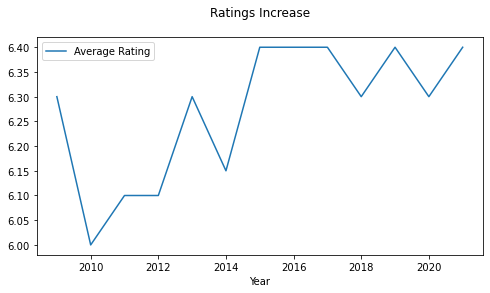

In [45]:
annual_ratings.plot(kind='line')
plt.legend(['Average Rating'])
plt.title('Ratings Increase\n');

# **Graph network plot and determine centrality**

In [46]:
titles = watchlist

In [47]:
G = nx.Graph()  # prototype for logic in main project module
edge_attribute_dict = {}
for name_ID, titles in nm_tt.items():
    G.add_node(name_ID)  # save people as nodes
    for title in titles:
        for name_ID2, titles2 in nm_tt.items():
            if (title in titles2) and (titles2 != titles):
                G.add_edge(name_ID, name_ID2)  # save movies as edges
                name_ID_tuple = tuple(sorted((name_ID, name_ID2)))
                if name_ID_tuple not in edge_attribute_dict:
                    edge_attribute_dict[name_ID_tuple] = 1
                else:
                    edge_attribute_dict[name_ID_tuple] += 1 # keep count of movies both starred in, for weight

In [48]:
for k,v in edge_attribute_dict.items():  # calculate centrality with weighted edges of more movies costarred in
    edge_attribute_dict[k] = {'weight':v}

In [49]:
import matplotlib.colors as mcolors   # courtesy of aksakalli.github.io
pos = nx.spring_layout(G, seed=675)
def draw(G, pos, measures, measure_name):  # use this function for nicer looking color graphs below
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())  # removed color line, caused errors
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [50]:
plt.rcParams["figure.figsize"] = (15, 10)  # make these three graphs a little larger for analysis

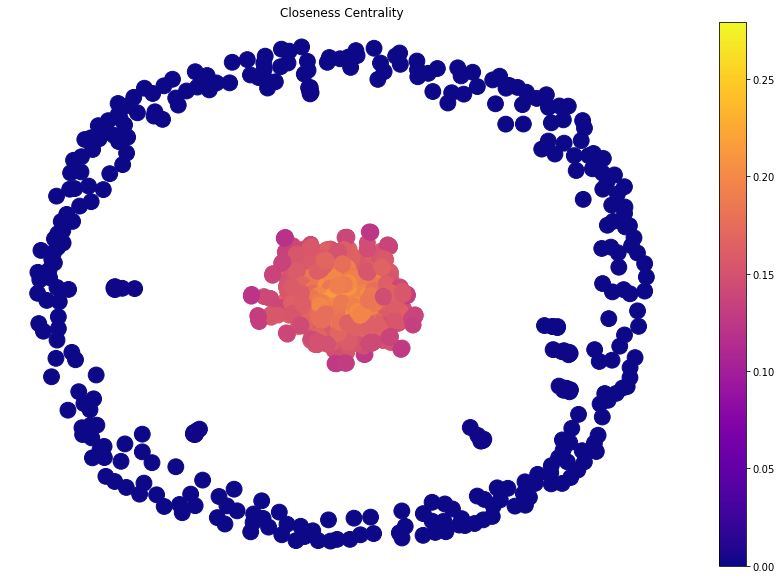

In [51]:
draw(G, pos, nx.closeness_centrality(G), 'Closeness Centrality')  # uses draw function coded above

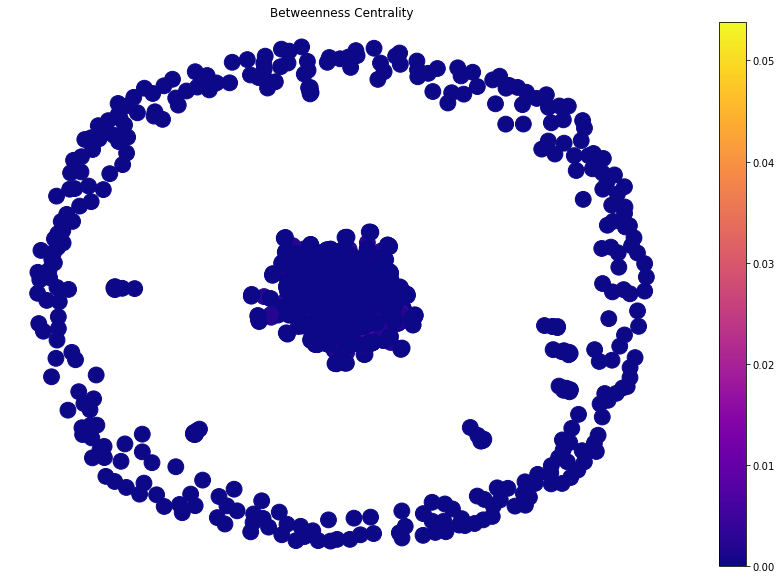

In [52]:
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')  # similar results, main cluster and "fringe"

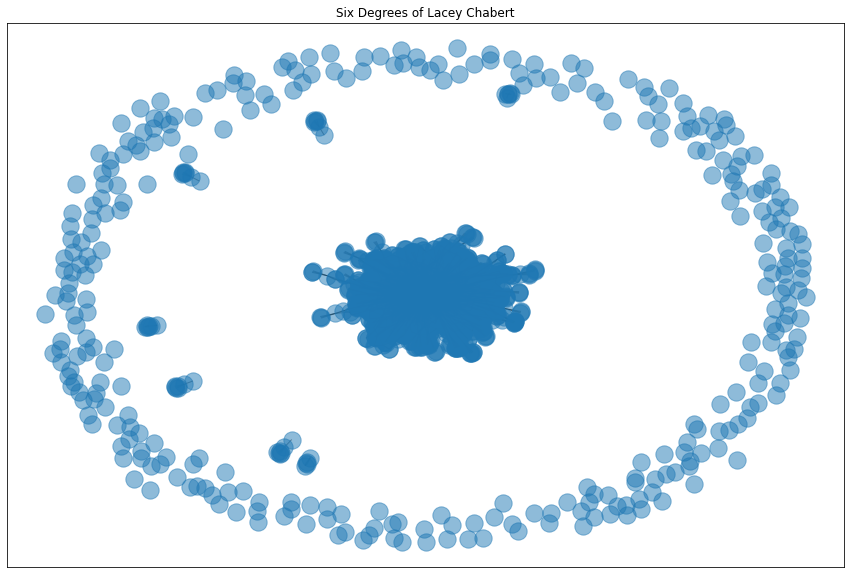

In [53]:
#color_map = [n[1]['color'] for n in G.nodes(data=True)]  # plot with an alpha value for strength of centrality
labels = {n:n for n in G.nodes()}
plt.title('Six Degrees of Lacey Chabert')
nx.draw_networkx(G, alpha=0.5, labels=labels, with_labels=False)
#nx.draw_networkx(G, node_color=color_map, alpha=0.5, labels=labels, with_labels=False)

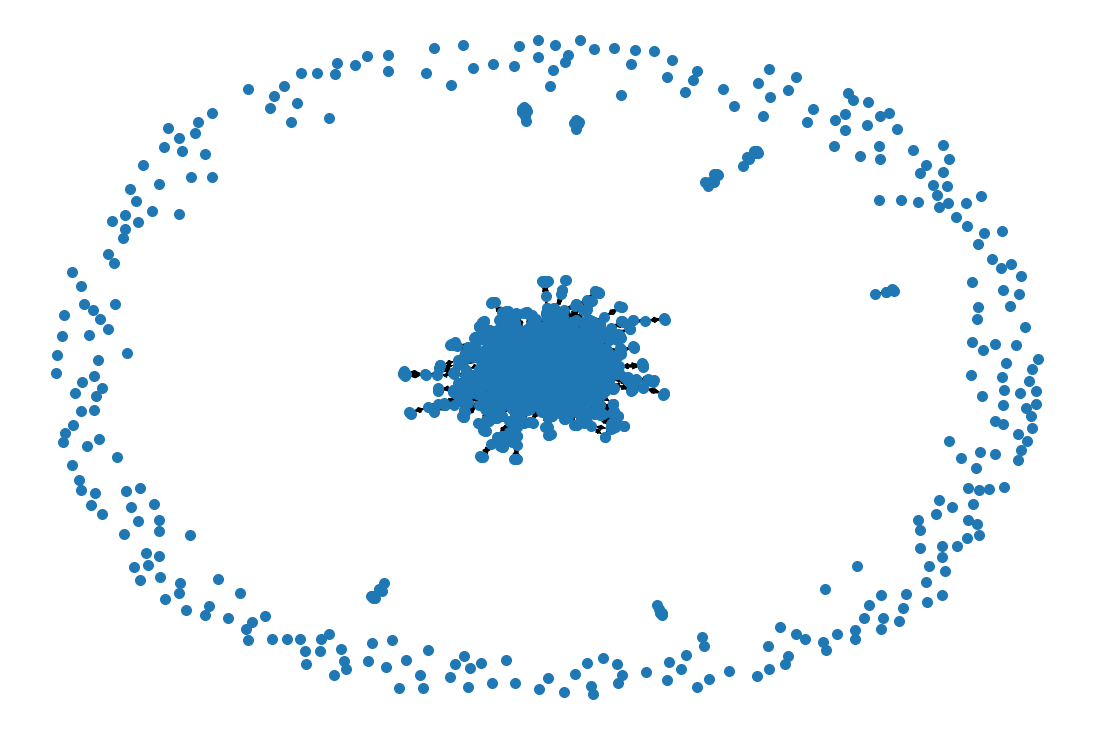

In [54]:
nx.draw_spring(G.to_directed(), node_size=100)  # some fringe people only acted in 1 movie in the list

In [55]:
between_ity = nx.betweenness_centrality(G)  # comfirms general results of main prgoject, few variations in Top 20
[(nm_name[x], between_ity[x]) for x in sorted(between_ity, key=between_ity.get, reverse=True)[:10]]

[('Lacey Chabert', 0.05378388747600292),
 ('Andrew W. Walker', 0.039791565438469595),
 ('Cindy Busby', 0.03142992282708718),
 ('Candace Cameron Bure', 0.03101284389823941),
 ('Danica McKellar', 0.029818411144530352),
 ('Trevor Donovan', 0.027440188481101538),
 ('Jen Lilley', 0.02567108387900853),
 ('Alison Sweeney', 0.023808686187877195),
 ('Corey Sevier', 0.023466145149259893),
 ('Stephen Huszar', 0.022368595798011343)]

In [56]:
close_ity = nx.closeness_centrality(G)  # not as useful without removing titles from list
[(nm_name[x], close_ity[x]) for x in sorted(close_ity, key=close_ity.get, reverse=True)[:10]]

[('Lacey Chabert', 0.27908807591534335),
 ('Andrew W. Walker', 0.2735418778047684),
 ('Barbara Niven', 0.26662547072143034),
 ('Danica McKellar', 0.26544796974665585),
 ('Candace Cameron Bure', 0.26393267835026835),
 ('Christopher Russell', 0.26152111073082424),
 ('Niall Matter', 0.26046339137498675),
 ('Autumn Reeser', 0.26038816729083514),
 ('Alison Sweeney', 0.26031298664487273),
 ('Jen Lilley', 0.25956356103196104)]

In [57]:
G1 = nx.Graph()  # this approach uses actors and movies as nodes, for better SP and Degree Separation lookup
names = {}
for n, star in enumerate(movie_cast_crew.nconst.unique()):
    name = nm_name[star]
    names[star] = name
    G1.add_node(name)
for n, movie in enumerate(movie_cast_crew.tconst.unique()):
    name = tt_title[movie]
    names[movie] = name
    G1.add_node(name)    
for row in movie_cast_crew.index:
    star = movie_cast_crew['nconst'][row]
    s_name = names[star]
    movie = movie_cast_crew['tconst'][row]
    m_name = names[movie]
    G1.add_edge(s_name, m_name)
sp = nx.all_pairs_shortest_path(G1)  # saerved as SP source in main module of project, exported as pickle

In [58]:
lacey1 = nx.single_source_shortest_path(G1, 'Lacey Chabert', cutoff=7) # can map specific distances (not used here)

In [59]:
path = nx.single_source_shortest_path(G1, 'Lacey Chabert')  # map of all Degrees of Separation from Lacey Chabert

In [60]:
path['Autumn Reeser']  # has Autumn ever starred with Lacey? Yep, in "The Wedding Veil"

['Lacey Chabert', 'The Wedding Veil', 'Autumn Reeser']

In [61]:
path['Cindy Busby']  # what about Cindy? She starred in Wedding March w/Tyler, who was in Winter in Vail w/Lacey

['Lacey Chabert',
 'Winter in Vail',
 'Tyler Hynes',
 "Wedding March 5: My Boyfriend's Back",
 'Cindy Busby']

In [62]:
movie_cast_crew.head()  # could refactor and keep director, cinematographer, and writer in results

,tconst,nconst,category
0,tt0102842,nm0000335,actress
1,tt0102842,nm0000686,actor
2,tt0102842,nm0709634,actress
3,tt0102842,nm0825555,actress
4,tt0108159,nm0000335,actress


In [63]:
cast_crew_info.head()  # mean age of actors/actresses could be a feature for analysis 

,nconst,primaryName,birthYear,deathYear
0,nm0000137,Bo Derek,1956,\N
1,nm0000145,Sherilyn Fenn,1965,\N
2,nm0000157,Linda Hamilton,1956,\N
3,nm0000162,Anne Heche,1969,\N
4,nm0000176,Nastassja Kinski,1961,\N


In [64]:
movie_info.head()  # genres could be an feature for research later, as well as a seasonal feature (Christmas espec.)

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0102842,tvMovie,"Sarah, Plain and Tall",1991,98,"Drama,Family,Romance",7.3,2155
1,tt0108159,tvMovie,Skylark,1993,95,Drama,7.2,1010
2,tt0140340,tvMovie,The Love Letter,1998,99,"Fantasy,Romance",7.3,2090
3,tt0184799,tvMovie,Ordinary Miracles,2005,85,Drama,6.4,530
4,tt0192573,tvMovie,"Sarah, Plain & Tall: Winter's End",1999,95,Drama,6.8,954


In [65]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 0 to 1140
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          1141 non-null   object 
 1   titleType       1141 non-null   object 
 2   primaryTitle    1141 non-null   object 
 3   startYear       1136 non-null   Int64  
 4   runtimeMinutes  1141 non-null   int64  
 5   genres          1141 non-null   object 
 6   averageRating   1141 non-null   float64
 7   numVotes        1141 non-null   int64  
dtypes: Int64(1), float64(1), int64(2), object(4)
memory usage: 81.3+ KB


In [66]:
cast_crew_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2463 entries, 0 to 2462
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nconst       2463 non-null   object
 1   primaryName  2463 non-null   object
 2   birthYear    2463 non-null   object
 3   deathYear    2463 non-null   object
dtypes: object(4)
memory usage: 96.2+ KB


In [67]:
movie_cast_crew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4702 entries, 0 to 4701
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tconst    4702 non-null   object
 1   nconst    4702 non-null   object
 2   category  4702 non-null   object
dtypes: object(3)
memory usage: 276.0+ KB


# **Actor analysis -- who starred in the most movies?**

In [68]:
nm_tt #let's peek at the database structure

{'nm0000137': ['tt10302982'],
 'nm0000145': ['tt3729860'],
 'nm0000157': ['tt0338434'],
 'nm0000162': ['tt0457477', 'tt3725224', 'tt6217490'],
 'nm0000176': ['tt0217066'],
 'nm0000222': ['tt5211694', 'tt5459456', 'tt5541330'],
 'nm0000227': ['tt6288876'],
 'nm0000261': ['tt1708658'],
 'nm0000268': ['tt0375139'],
 'nm0000284': ['tt0363827'],
 'nm0000287': ['tt2288568', 'tt4882698', 'tt6295106'],
 'nm0000304': ['tt0363827'],
 'nm0000308': ['tt0402260', 'tt0950740', 'tt1297854'],
 'nm0000310': ['tt10768456',
  'tt11686340',
  'tt13178100',
  'tt1672621',
  'tt6619330',
  'tt8783262'],
 'nm0000327': ['tt10344956',
  'tt11439610',
  'tt11585200',
  'tt11686354',
  'tt13169850',
  'tt14113198',
  'tt14477372',
  'tt1492820',
  'tt15943556',
  'tt16287754',
  'tt2400685',
  'tt2838678',
  'tt3004852',
  'tt3579250',
  'tt4460176',
  'tt4587740',
  'tt4766018',
  'tt5676118',
  'tt6587078',
  'tt7030432',
  'tt7243076',
  'tt7905880',
  'tt7997256',
  'tt8020378',
  'tt8589788',
  'tt8634192',

In [69]:
actorlist[:3]  # let's verify we still have a list of Hallmark actors by code

['nm0339797', 'nm0569787', 'nm0001337']

In [70]:
name_count = {}  # create a dictionary to store the sorted movie count by actor
for actor in actorlist:
    name_count[nm_name[actor]] = len(nm_tt[actor])  # count movies for each actor, store in dictionary
sorted_dict = sorted([(value, key)
 for (key, value) in name_count.items()])  # sort the dictionary
df = pd.DataFrame(sorted_dict, columns =["Movies", "Actor"])  # rename the columns for display
df = df.sort_values(by='Movies', ascending=False) # reverse sort the movie count so we can grab top 10 (or more)
df[:10]  # Sure enough, data confirms Lacey Chabert is the Queen of RomComs at Hallmark!

,Movies,Actor
2462,30,Lacey Chabert
2461,20,Andrew W. Walker
2460,19,Brennan Elliott
2459,18,Cindy Busby
2458,17,Jill Wagner
2457,17,Candace Cameron Bure
2456,16,Lori Loughlin
2455,16,Danica McKellar
2454,16,Barbara Niven
2452,15,Kellie Martin


In [71]:
df.describe()  # let's see how top 10 compare to the pack (spoiler alert... Kellie is 99.6 percentile)

,Movies
count,2463.000000
mean,1.909054
std,2.176384
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,30.000000


In [72]:
print(df['Movies'].quantile(q=0.990), df['Movies'].quantile(q=0.993), df['Movies'].quantile(q=0.996))

12.0 13.0 15.0


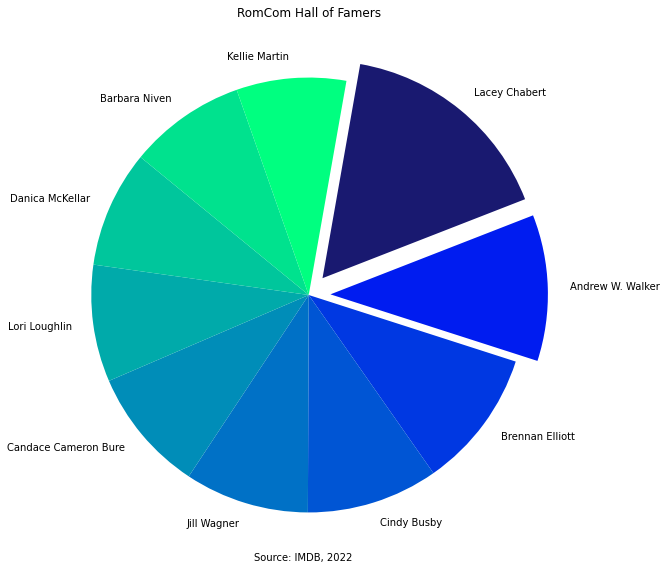

In [73]:
top_10 = df[:10]
values = list(top_10['Movies'])  # let's chart the Top 10 on a pie chart, based on # movies starred in
labels = list(top_10['Actor'])
plt.title('RomCom Hall of Famers')
plt.annotate(r'Source: IMDB, 2022', xy=(.4, .01), xycoords='axes fraction')  # throw in a source attribution
colors = ['#191970','#001CF0','#0038E2','#0055D4','#0071C6','#008DB8',\
          '#00AAAA','#00C69C','#00E28E','#00FF80']  # use a blue-green spectrum for the wheel
explode = (.1, .1, 0, 0, 0, 0, 0, 0, 0, 0)  # callout the two two, female and male
plt.pie(values, labels=labels, explode=explode, colors=colors, counterclock=False, shadow=False, startangle=80)
plt.show()